In [18]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.nn import functional
import math

# Hyper-parameters 
input_size = 784
num_classes = 10
num_epochs = 1
batch_size = 32
learning_rate = 1e-4

# MNIST dataset (images and labels)
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Binary ops

In [2]:
class Binarize(torch.autograd.Function):
    THRESHOLD_STE = True
    
    @staticmethod
    def forward(ctx, input):
        """
        We approximate the input by the following:
        
        input ~= sign(input) * l1_norm(input) / input.size
        """
        ctx.save_for_backward(input)
        return input.sign() * torch.mean(torch.abs(input))

    @staticmethod
    def backward(ctx, grad_output):
        """
        According to [Do-Re-Fa Networks](https://arxiv.org/pdf/1606.06160.pdf),
        the STE for binary weight networks is completely pass through.
        
        However, according to [Binary Neural Networks](https://arxiv.org/pdf/1602.02830.pdf),
        and [XNOR-net networks](https://arxiv.org/pdf/1603.05279.pdf),
        the STE must be thresholded by the following:
        
        d = d * (-1 <= w <= 1)
        
        Set THRESHOLD_STE to True/False for either behavior. However, it is suggested
        to set it to True because we have seen performance degradations with it = False.
        """
        if Binarize.THRESHOLD_STE:
            input, = ctx.saved_tensors
            grad_output[input.ge(1)] = 0
            grad_output[input.le(-1)] = 0
        return grad_output

class BinaryLinear(nn.Module):
    def __init__(self, in_features, out_features):
        """
        Takes in some inputs x, and initializes some weights for matmul,
        and performs a bitcount(xor(x, weights)).
        
        input = (N, M)
        weights = (M, K)
        
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to False, the layer will not learn an additive bias.
            Default: ``True``
        """
        super(BinaryLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        
        # Initializing parameters
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)        

    def forward(self, input):
        binarize = Binarize.apply
        return functional.linear(binarize(input), binarize(self.weight), binarize(self.bias))
    
class BinaryConvolution2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, bias=True):
        """
        Takes in some inputs x, and initializes some weights for conv filters,
        and performs a "convolution" by binarizing the weights and multiplying
        the inputs by the binarized weights.
        
        input = (N, C, H, W)
        weights = (K, C, H, W) [ to be binarized ]
        biases = (K,) [ to be binarized ]
        output = (N, K, H, W)
        
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int): Size of the convolving kernel
        stride (int or tuple, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        bias (bool, optional): If ``True``, adds a learnable bias to the output. Default: ``True``
        
        NOTE: We skip dilation, groups, etc for now.
        """
        super(BinaryConvolution2d, self).__init__()
        self.weight = torch.nn.Parameter(torch.Tensor(out_channels, in_channels, *(kernel_size, kernel_size)))
        self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
        self.stride = stride
        self.padding = padding
        
        # Initializing parameters
        n = in_channels
        n *= kernel_size ** 2 # number of parameters
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)
        
    def forward(self, input):
        binarize = Binarize.apply
        return functional.conv2d(binarize(input), binarize(self.weight), binarize(self.bias), self.stride, self.padding)

# Testing

In [3]:
# Testing Binarize:
# Create random Tensors to hold input and outputs.
x = torch.randn(1, 3, requires_grad=True)

b = Binarize.apply

# Forward pass: compute predicted y using operations; we compute
# ReLU using our custom autograd operation.
for _ in range(10):
    y = b(x)
    loss = (y - torch.FloatTensor([1,2,3])).pow(2).sum()
    loss.backward()

    print(x)
    print(y)
    print(loss.item())
    # Update weights using gradient descent
    with torch.no_grad():
        x -= x.grad * 1e-1
        print(x.grad)
        x.grad.zero_()
    print("---")

tensor([[-0.1193, -0.2836, -0.2486]])
tensor([[-0.2172, -0.2172, -0.2172]])
16.747344970703125
tensor([[-2.4343, -4.4343, -6.4343]])
---
tensor([[ 0.1242,  0.1598,  0.3949]])
tensor([[ 0.2263,  0.2263,  0.2263]])
11.438299179077148
tensor([[-1.5474, -3.5474, -5.5474]])
---
tensor([[ 0.2789,  0.5146,  0.9496]])
tensor([[ 0.5810,  0.5810,  0.5810]])
8.040512084960938
tensor([[-0.8380, -2.8380, -4.8380]])
---
tensor([[ 0.3627,  0.7983,  1.4334]])
tensor([[ 0.8648,  0.8648,  0.8648]])
5.865927219390869
tensor([[-0.2704, -2.2704,  0.0000]])
---
tensor([[ 0.3897,  1.0254,  1.4334]])
tensor([[ 0.9495,  0.9495,  0.9495]])
5.310605049133301
tensor([[-0.1010,  0.0000,  0.0000]])
---
tensor([[ 0.3998,  1.0254,  1.4334]])
tensor([[ 0.9529,  0.9529,  0.9529]])
5.289422035217285
tensor(1.00000e-02 *
       [[-9.4253,  0.0000,  0.0000]])
---
tensor([[ 0.4093,  1.0254,  1.4334]])
tensor([[ 0.9560,  0.9560,  0.9560]])
5.269712924957275
tensor(1.00000e-02 *
       [[-8.7970,  0.0000,  0.0000]])
---
tens

In [14]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            BinaryConvolution2d(1, 16, kernel_size=5, stride=1, padding=2),
            # nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.BatchNorm2d(16),
            BinaryConvolution2d(16, 32, kernel_size=5, stride=1, padding=2),
            # nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
        )
        # self.fc = nn.Linear(7*7*32, num_classes) 
        self.fc = BinaryLinear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # Flatten
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

In [19]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
losses = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/1], Step [10/1875], Loss: 1.9302
Epoch [1/1], Step [20/1875], Loss: 0.0564
Epoch [1/1], Step [30/1875], Loss: 0.8536
Epoch [1/1], Step [40/1875], Loss: 0.9208
Epoch [1/1], Step [50/1875], Loss: 0.3538
Epoch [1/1], Step [60/1875], Loss: 1.0371
Epoch [1/1], Step [70/1875], Loss: 0.8205
Epoch [1/1], Step [80/1875], Loss: 1.8055
Epoch [1/1], Step [90/1875], Loss: 0.2843
Epoch [1/1], Step [100/1875], Loss: 0.1688
Epoch [1/1], Step [110/1875], Loss: 0.3524
Epoch [1/1], Step [120/1875], Loss: 0.0183
Epoch [1/1], Step [130/1875], Loss: 1.7730
Epoch [1/1], Step [140/1875], Loss: 0.5387
Epoch [1/1], Step [150/1875], Loss: 1.1975
Epoch [1/1], Step [160/1875], Loss: 0.5156
Epoch [1/1], Step [170/1875], Loss: 0.2278
Epoch [1/1], Step [180/1875], Loss: 0.8207
Epoch [1/1], Step [190/1875], Loss: 0.0156
Epoch [1/1], Step [200/1875], Loss: 1.1427
Epoch [1/1], Step [210/1875], Loss: 0.2397
Epoch [1/1], Step [220/1875], Loss: 0.6977
Epoch [1/1], Step [230/1875], Loss: 1.0472
Epoch [1/1], Step [2

In [20]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 10000 test images: 92.53 %


In [12]:
print(repr(model))

ConvNet(
  (layer1): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BinaryConvolution2d()
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BinaryConvolution2d()
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): BinaryLinear()
)


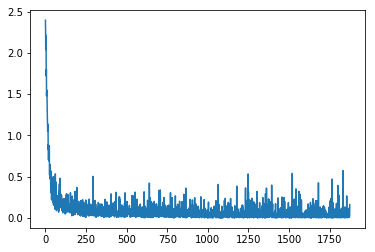

In [10]:
plt.plot(losses)
plt.show()